In [1]:
THRES = 10

In [96]:
ASN_TO_NAME = dict()
for l in open("asn.txt","r").readlines():
    name, asn = l.strip().split(" ")
    ASN_TO_NAME[asn] = name

In [97]:
from collections import defaultdict, deque
from datetime import datetime
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [98]:
class DataManager:
    def __init__(self, filename):
        self.data = defaultdict(lambda: defaultdict(lambda: [[] for _ in range(24)] ))
        self.softbank = []
        self.au_v4 = []
        self.au_v6 = []
        self.au_not = [convert("106.135.0.0/16")]
        
        self.load(filename)
        
        
    def load(self, filename):
        f = open("sb-mobile-1.txt",'r') 
        for subnet in f.readlines():
            self.softbank.append(convert(subnet.strip()))
        f.close()
        
        f = open("au-mobile-1.txt",'r') 
        for subnet in f.readlines():
            if ":" in subnet:
                self.au_v6.append(convert(subnet.strip()))
            else:
                self.au_v4.append(convert(subnet.strip()))
        f.close()
        
        f = open(f"{filename}", "r")
        for line in f.readlines()[1:] :
            self.process_line(line)
            
    def process_line(self, line):
        split = list(line.strip().split(","))
        
        date_time, mean, _, _, ip = split[:5]
        asn = split[-1]
        date, time = date_time.split(" ")
        
        if asn == "17676" :
            if ":" not in ip and contain(ip, self.softbank) :
                self.data[asn+'-cell'][date][int(time)].append( (float(mean), ) )                
            else: 
                self.data[asn+'-cable'][date][int(time)].append( (float(mean), ) )                
            
        if asn == "2516":
            if ":" in ip and contain(ip, self.au_v6) :
                self.data[asn+'-cell'][date][int(time)].append( (float(mean), ) )                
            elif ":" not in ip and contain(ip, self.au_v4) and not contain(ip, self.au_not):
                self.data[asn+'-cell'][date][int(time)].append( (float(mean), ) )  
            else : 
                self.data[asn+'-cable'][date][int(time)].append( (float(mean), ) )                
                
        self.data[asn][date][int(time)].append( (float(mean), ) )

In [99]:
def find_median(data):
    n = len(data)
    if n < THRES :
        return -1
    data.sort()
    return data[n//2][0] if n%2 else (data[n//2-1][0]+data[n//2][0])/2

In [100]:
def build_plot_data(data, st, end):
    x = []
    temp = [ [] for _ in range(24) ]
    y = []
    for dt in sorted(data.keys()) :
        if dt < st or dt > end:
            continue
        for i in range(24):
            temp[i] += data[dt][i]
    
    for i in range(24):
        v = find_median(temp[i])
        if v!=-1:
            y.append(v)
            x.append(i)
    return  x, y

In [135]:
def plot(data, st_list, end_list, title, jst=False):
    fig = plt.figure(figsize=(5,5), dpi=110)
    ax = fig.add_subplot(111)
    
    assert len(st_list) == len(end_list), "Dimension of st_list and end_list must equal"
    n = len(st_list)

    xticks = list(range(0,24,2))
    xticklabels = [ str(i) for i in xticks ]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel("Median Aggregated Throughput (MBpS)")
    if jst:
        ax.set_xlabel("Hour of a day (JST)")
    else :
        ax.set_xlabel("Hour of a day (UTC)")
    
    ax.set_ylim(data['ylim'][0], data['ylim'][1])
    for i in range(n):
        st, end = st_list[i], end_list[i]
        x, y = data['build'](data['data'], st, end)
        if jst :
            y = y[-9:] + y[:-9]
        ax.plot(x,y,"-o", label=data['label'][i])
        
    if n != 1 :
        ax.legend()
    ax.grid()
    fig.savefig(f"{title}.png")
    
    

In [136]:
# bq = DataManager('bq-full.csv')
# MAX = dict()
# MIN = dict()
path = ['pre', 'in', 'post']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


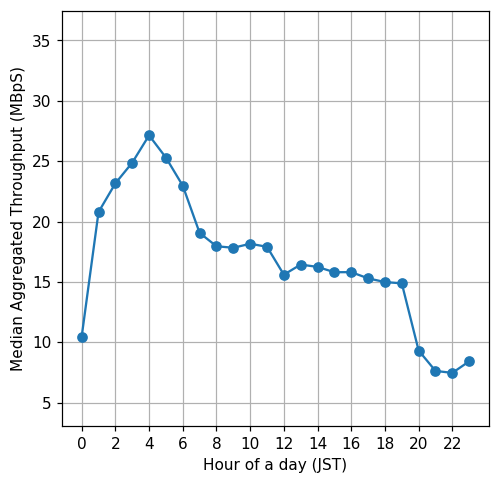

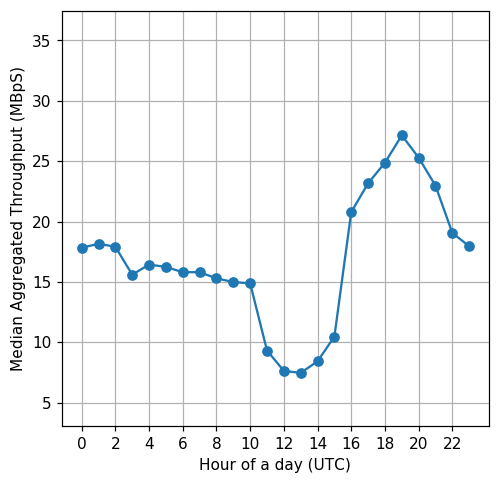

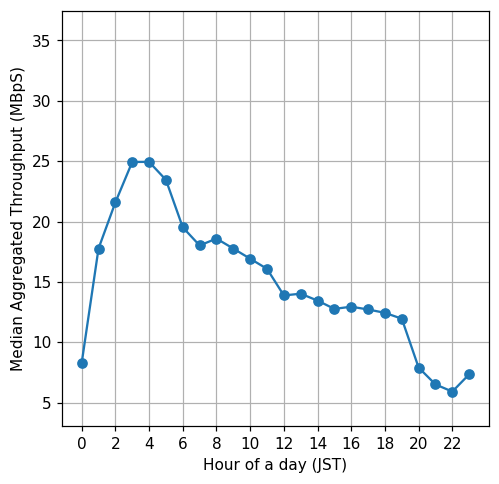

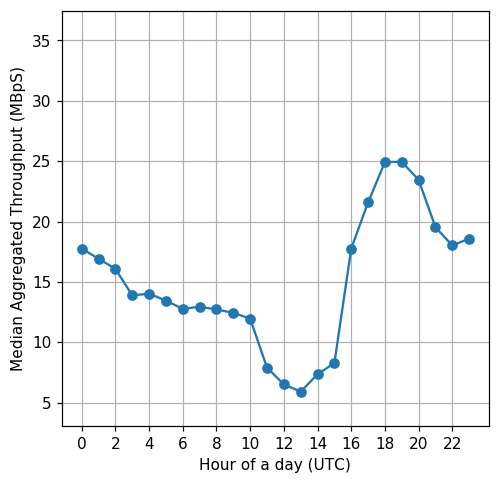

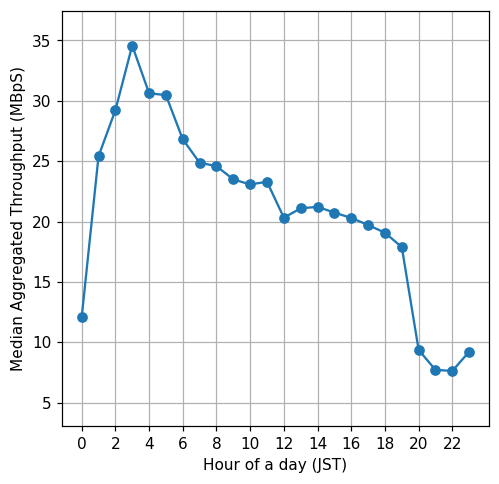

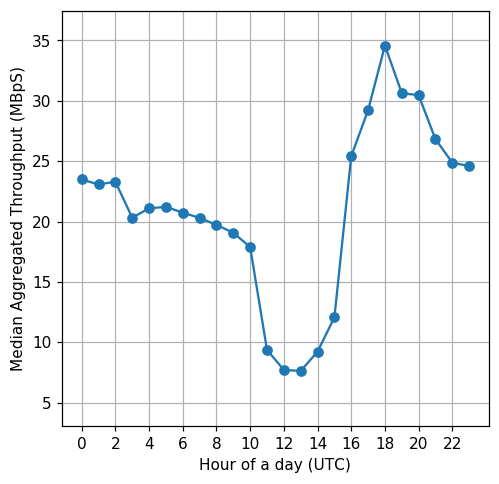

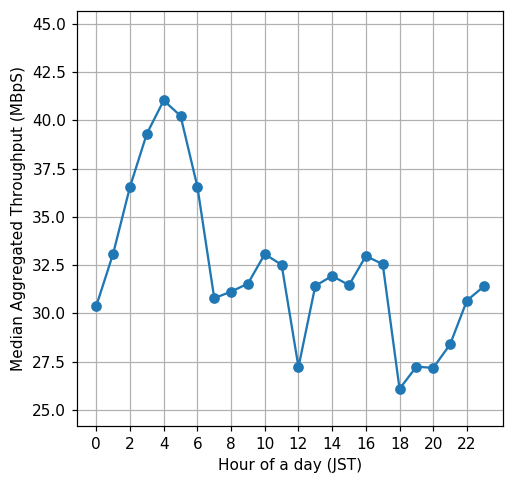

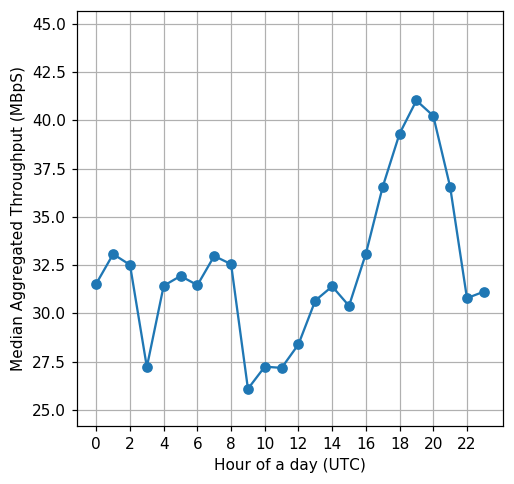

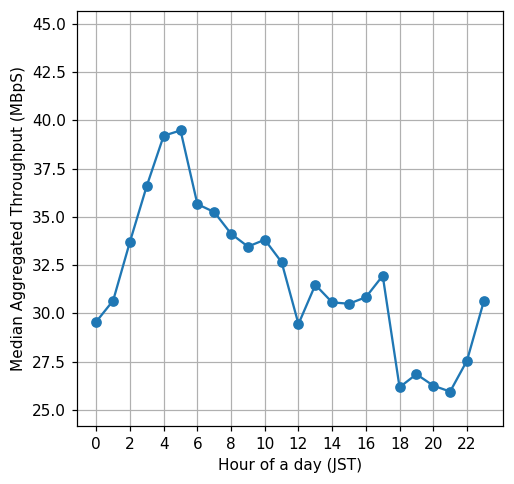

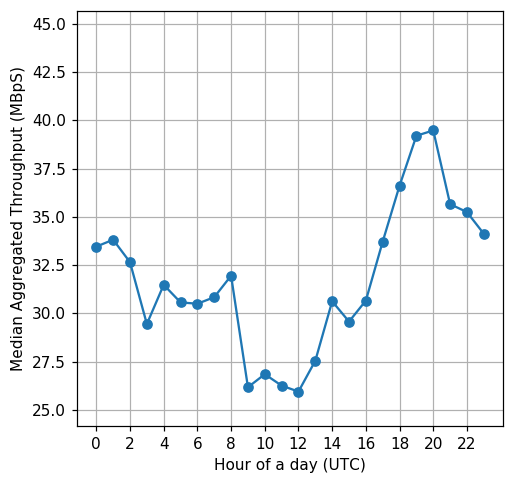

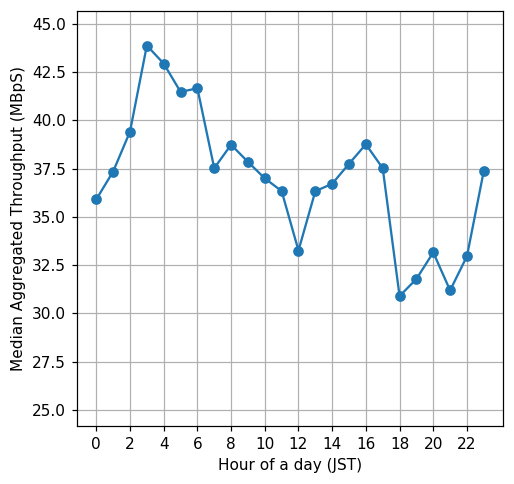

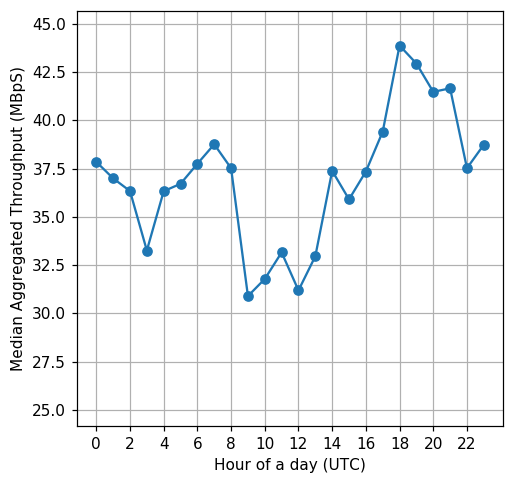

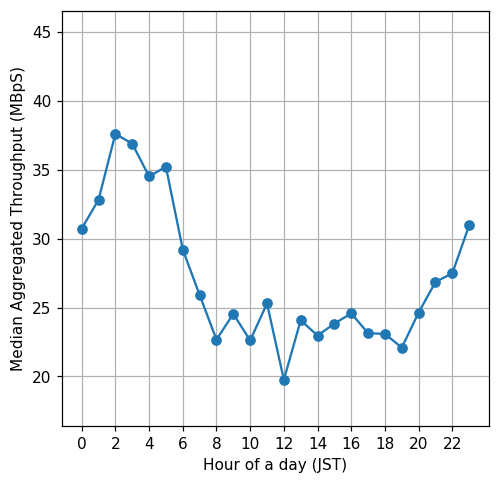

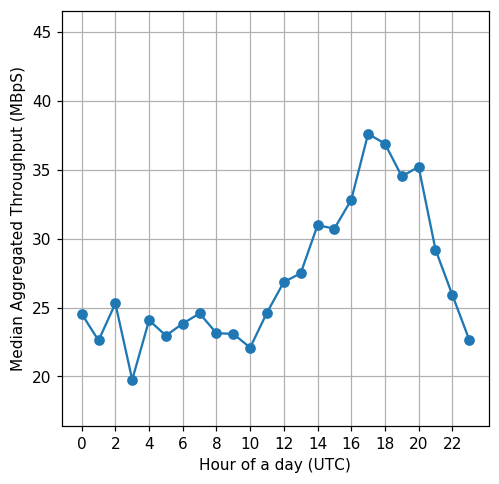

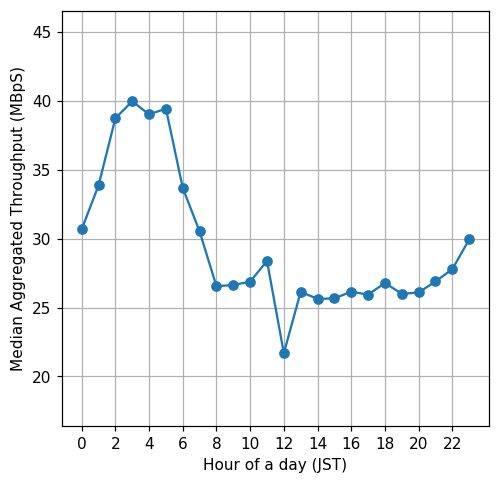

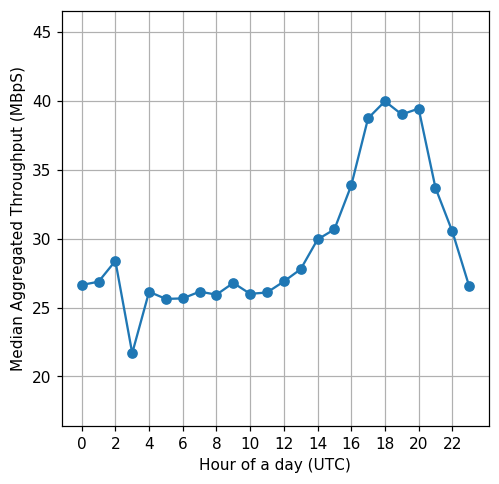

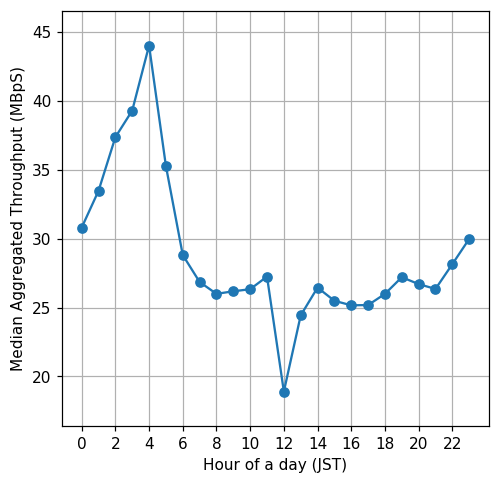

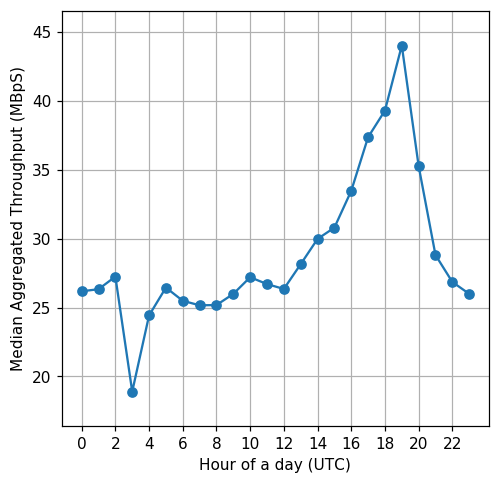

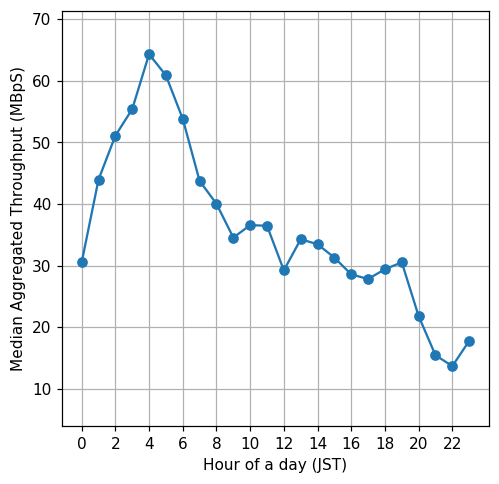

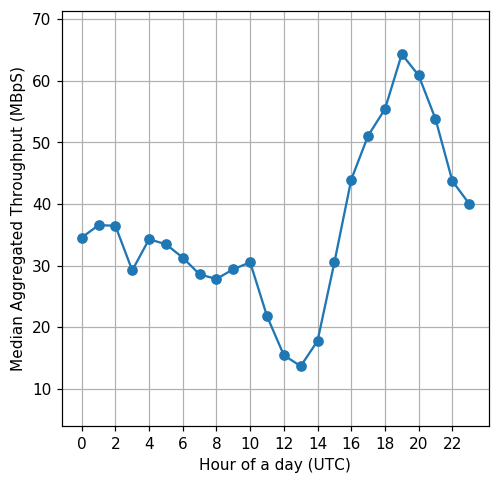

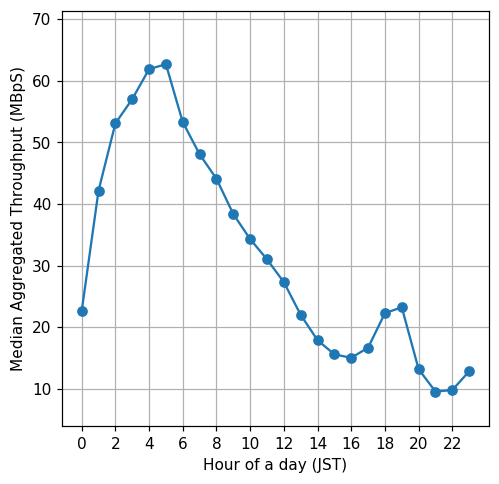

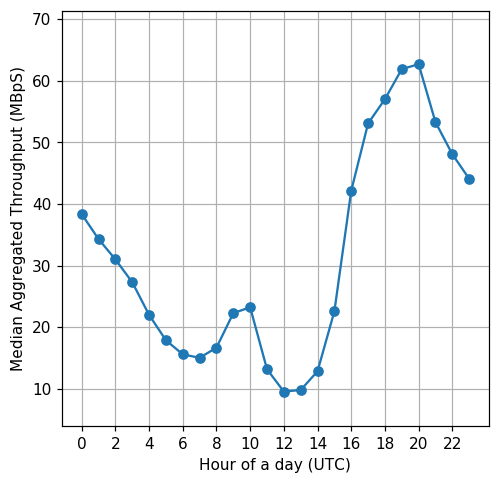

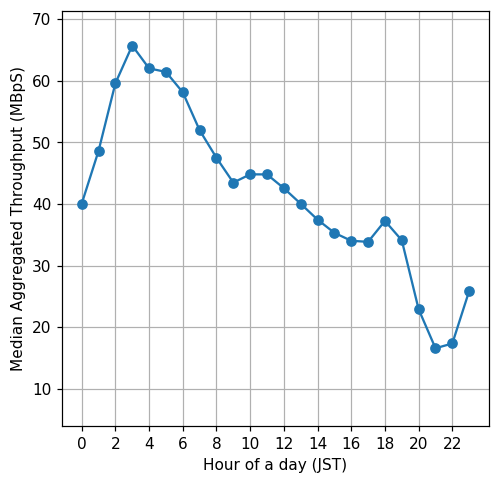

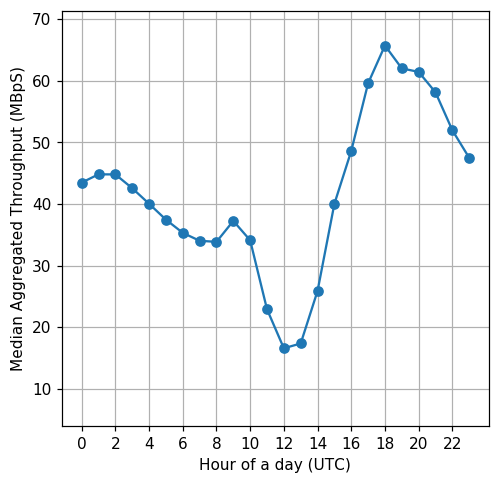

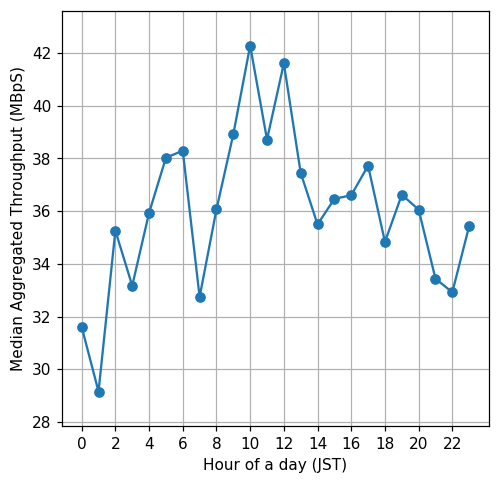

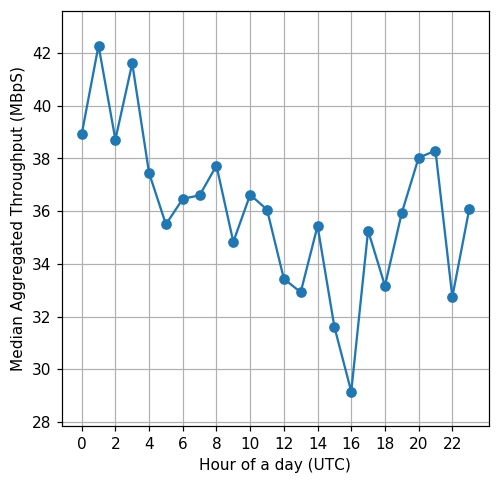

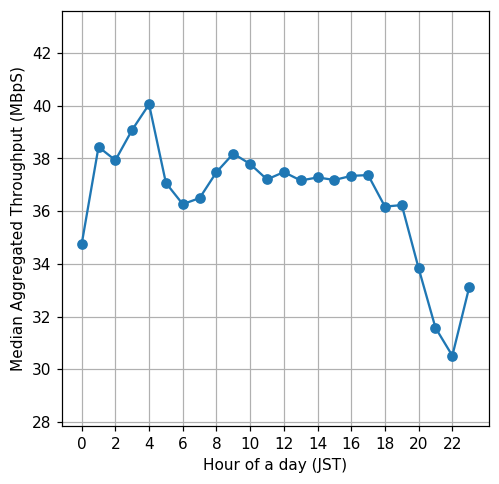

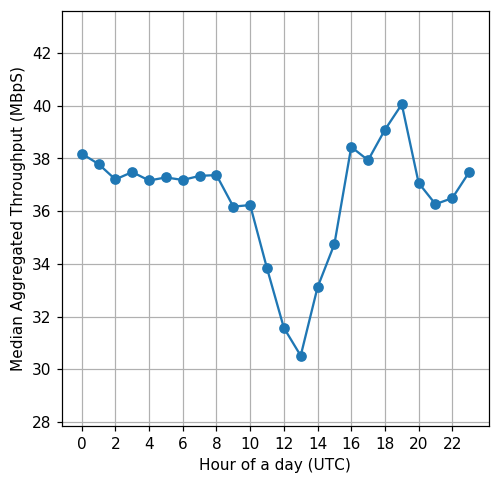

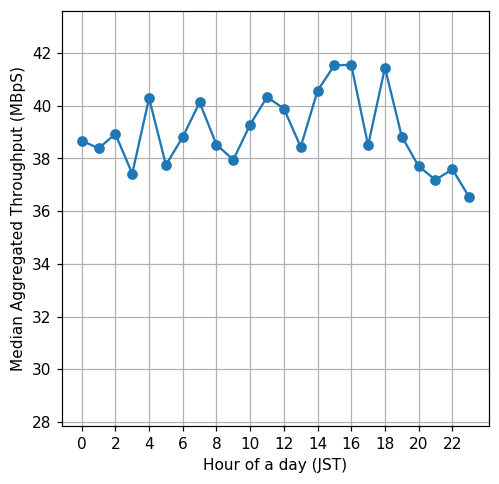

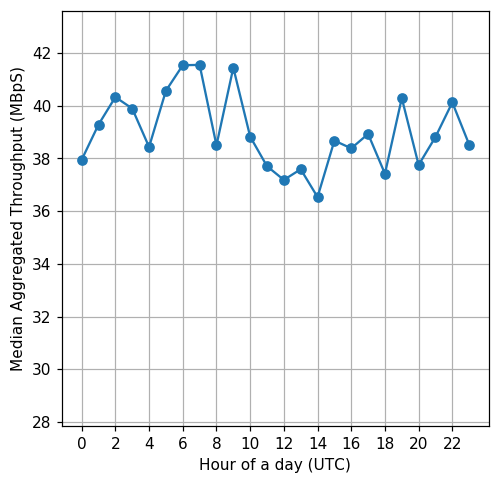

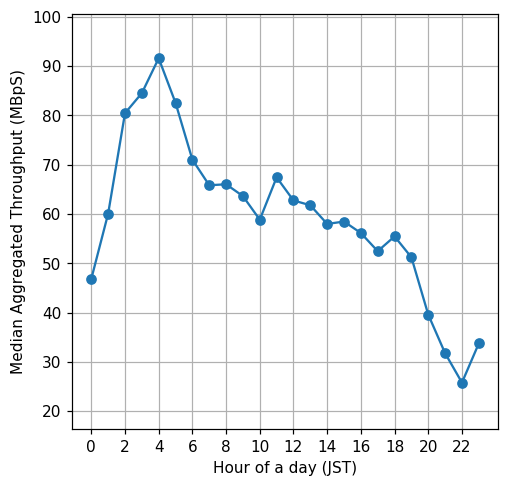

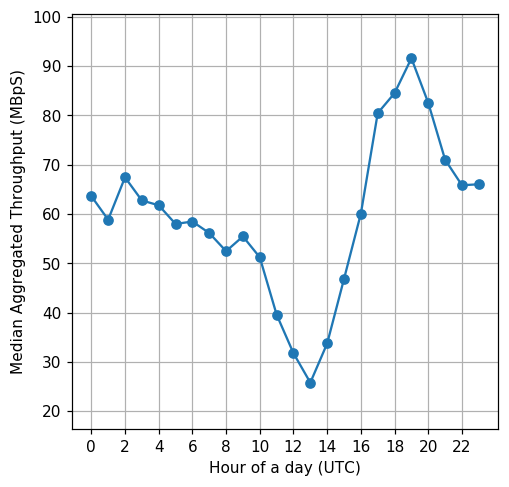

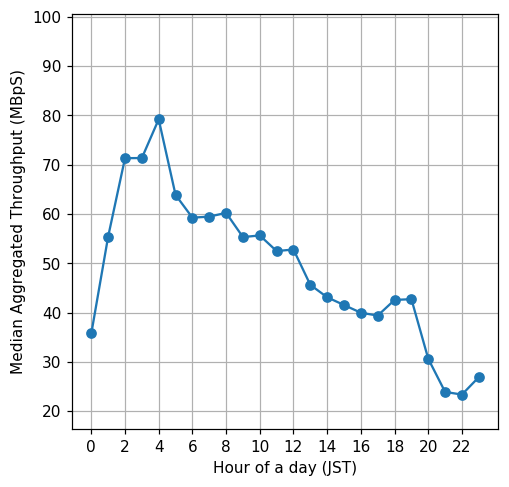

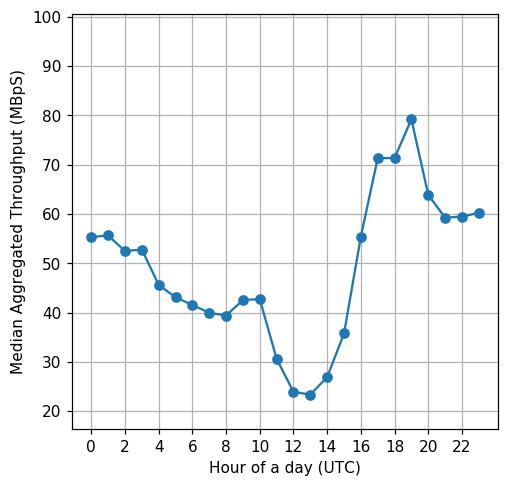

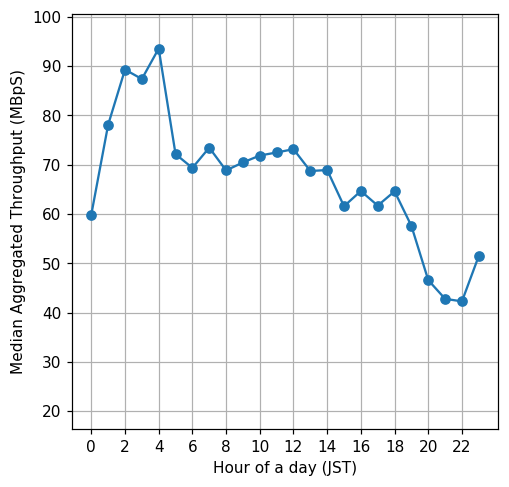

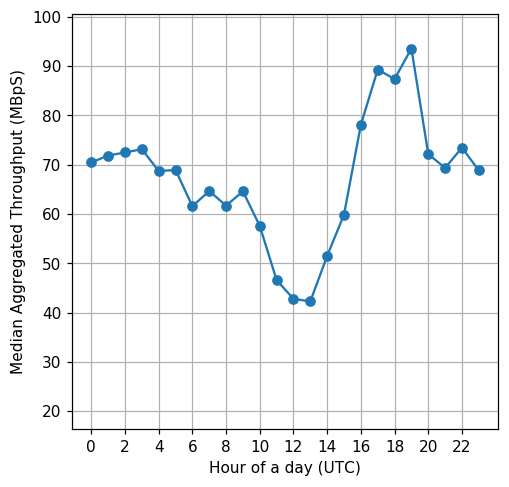

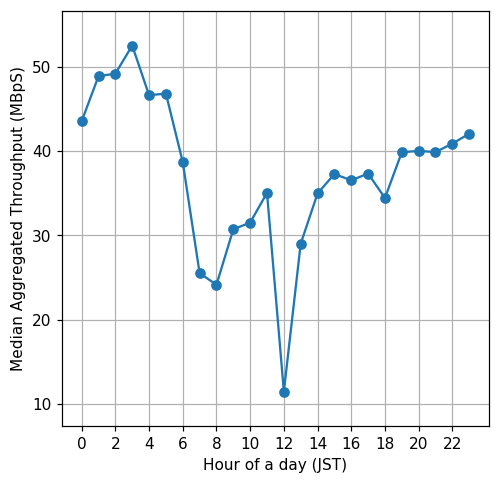

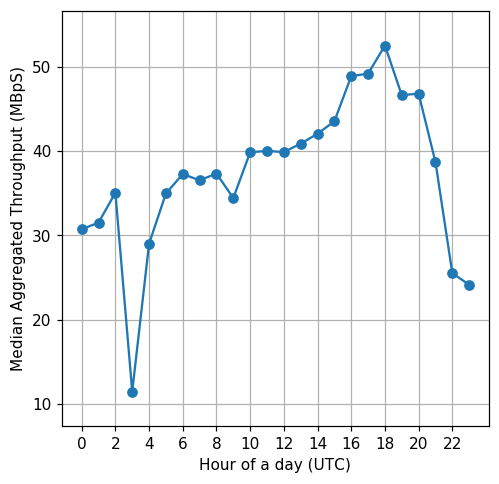

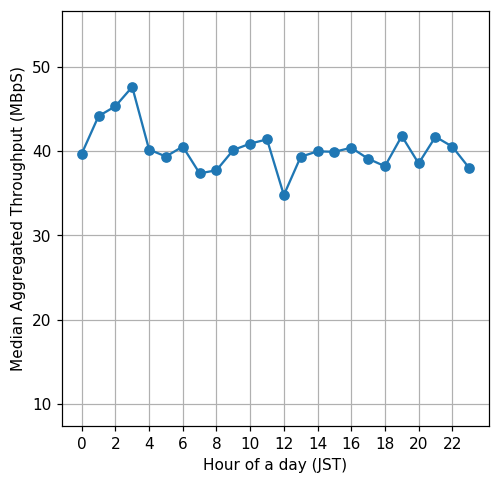

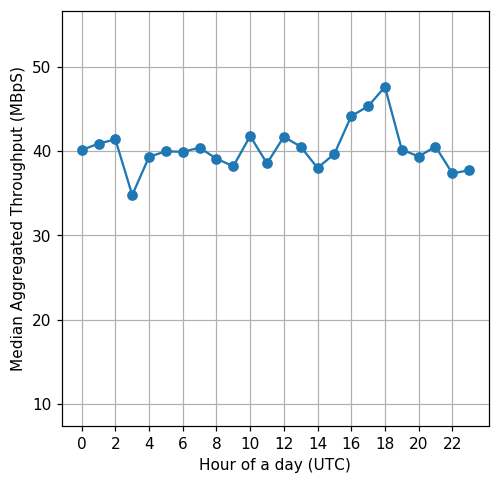

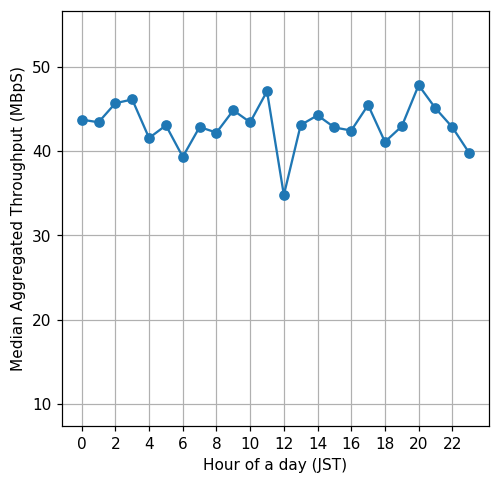

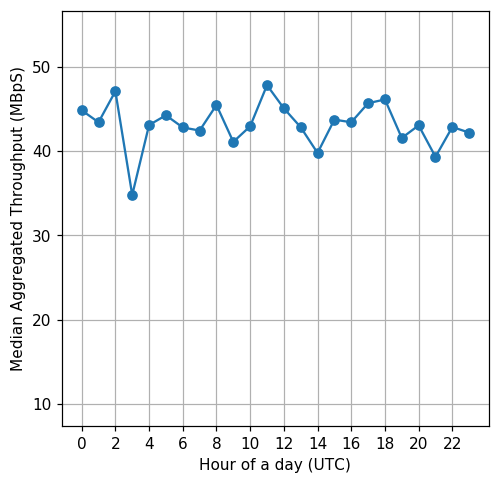

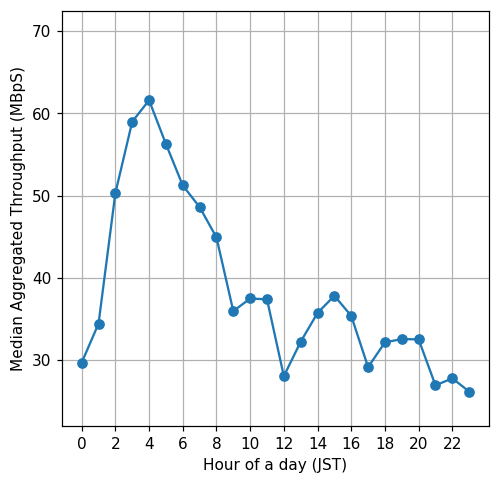

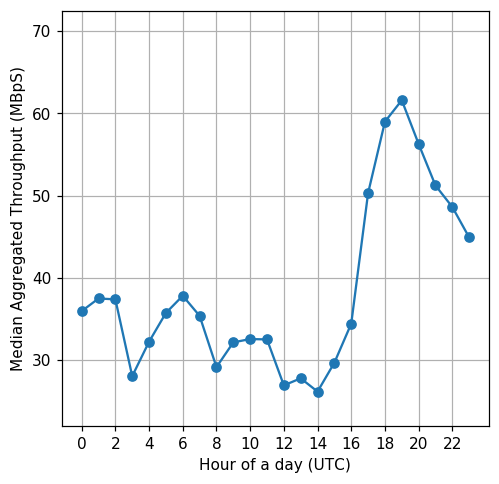

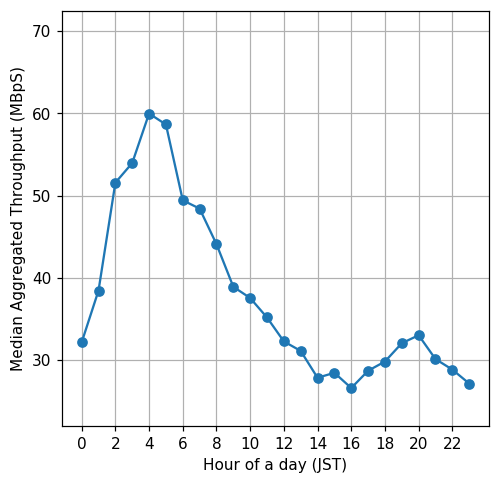

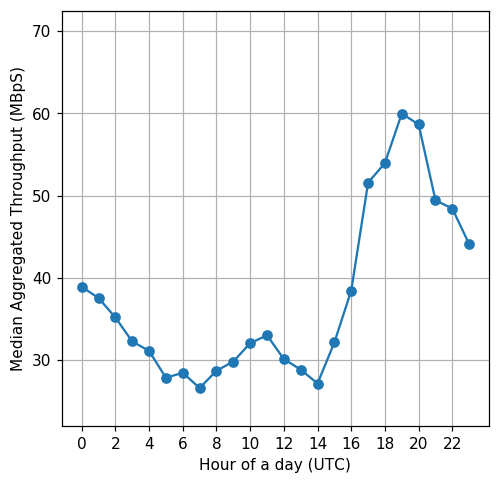

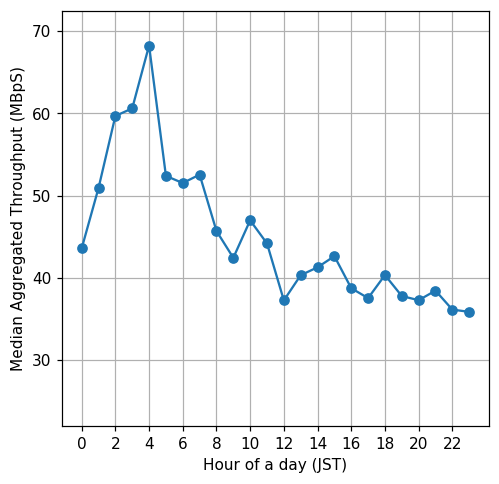

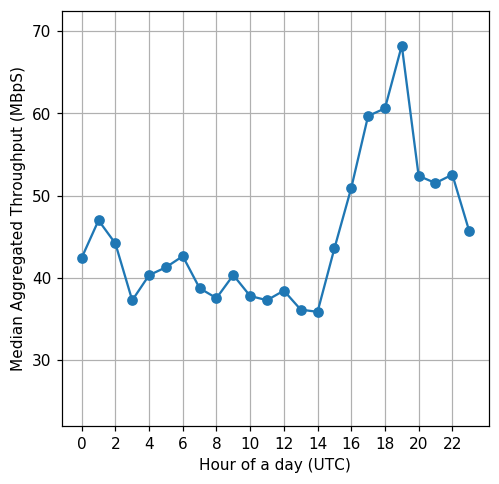

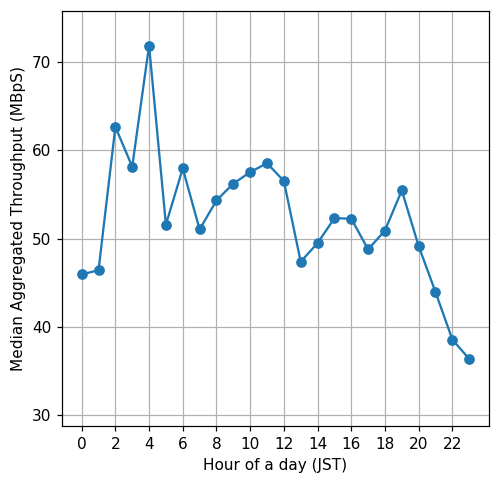

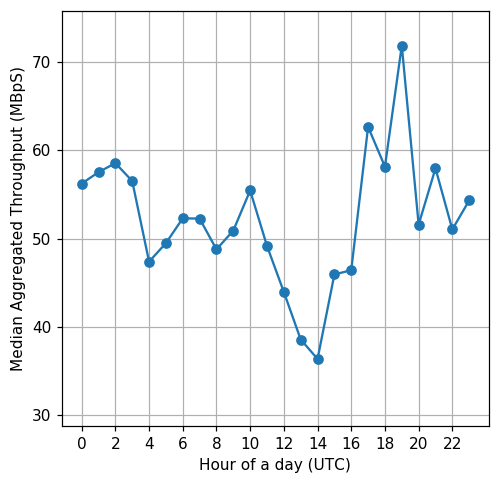

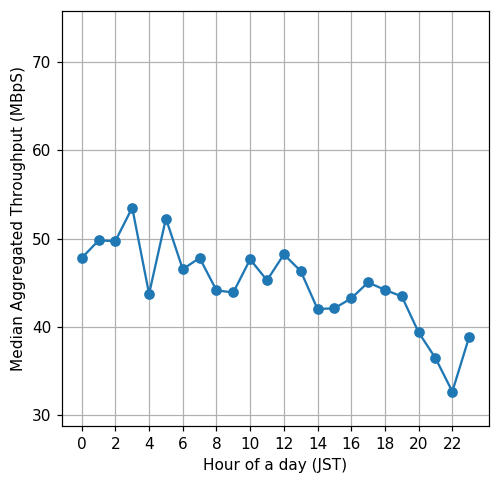

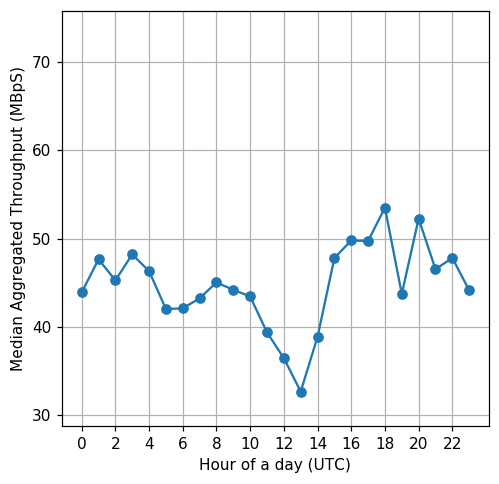

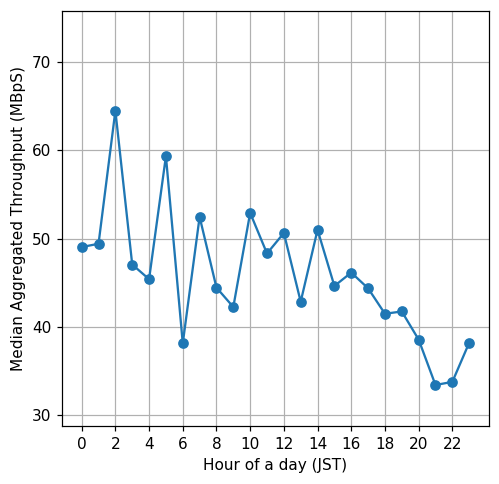

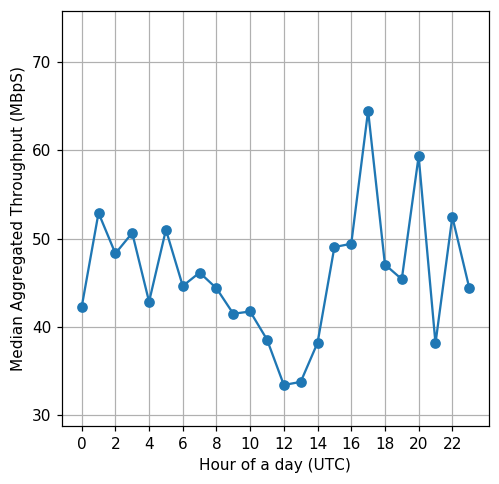

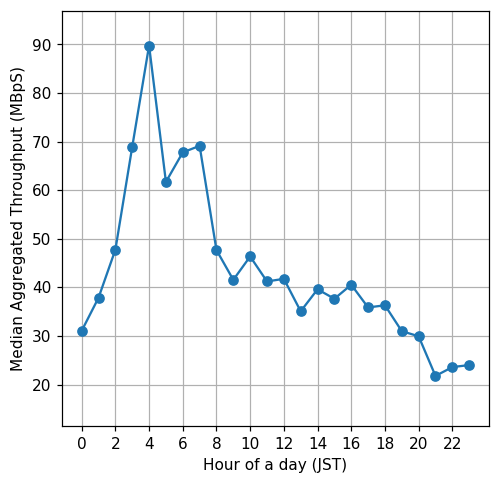

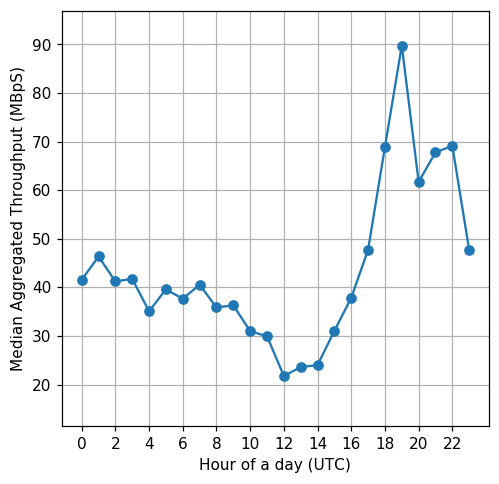

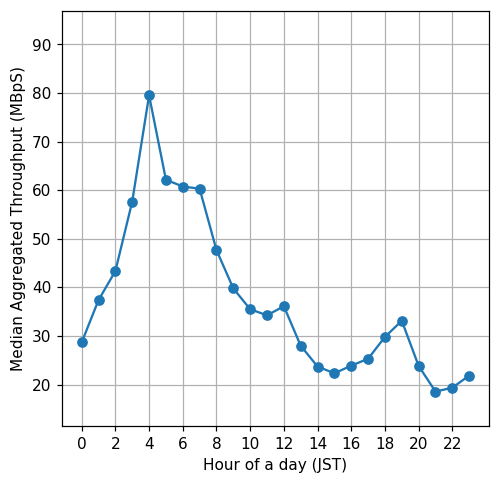

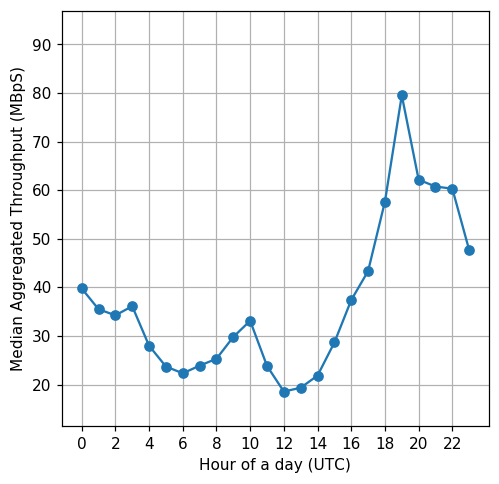

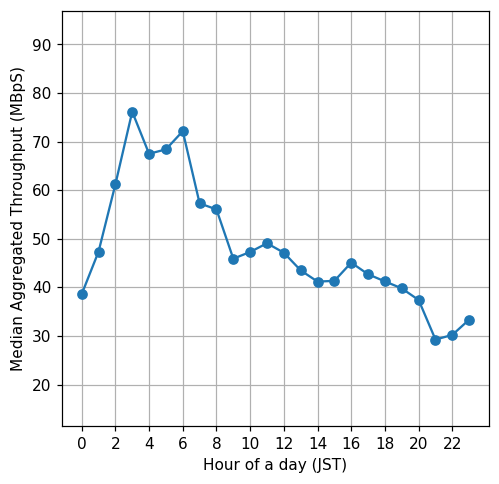

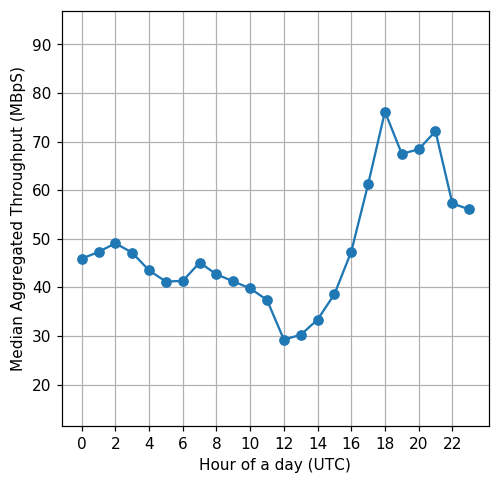

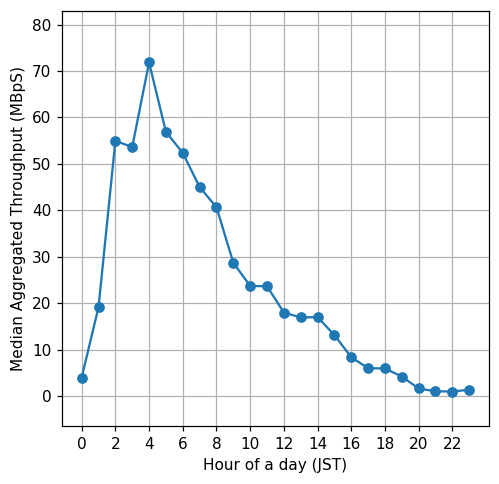

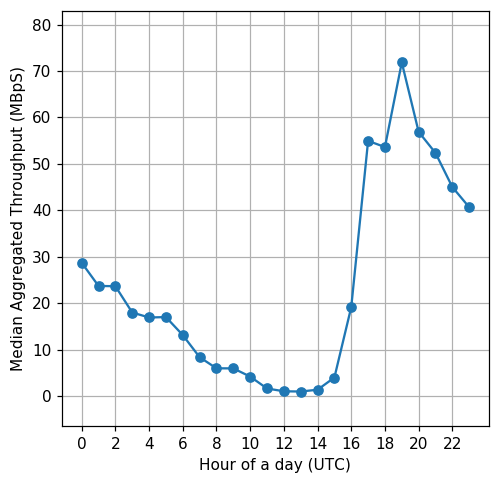

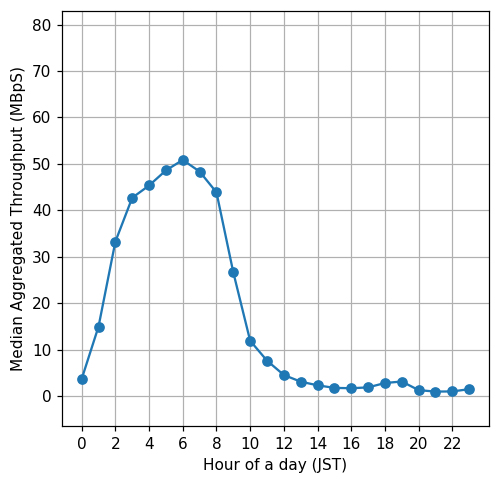

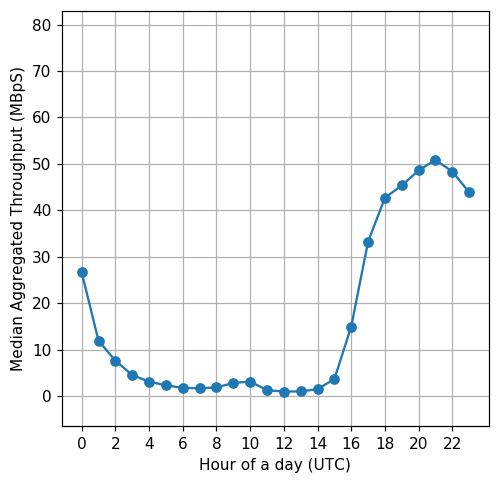

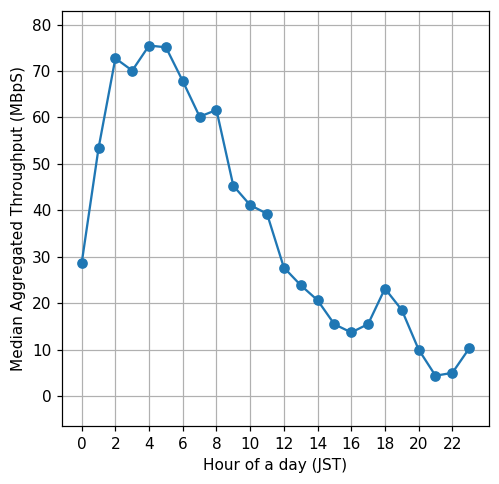

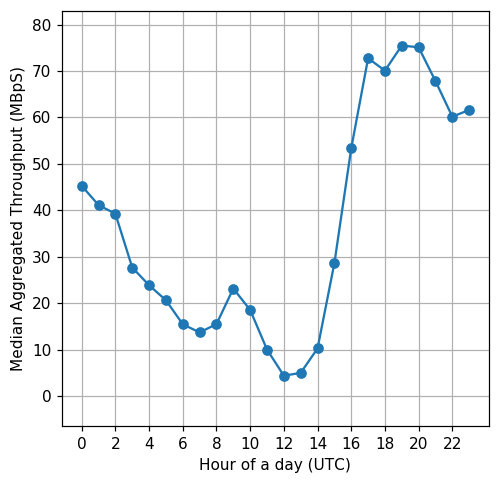

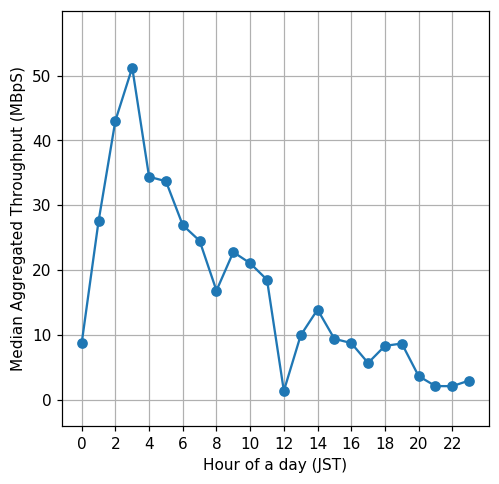

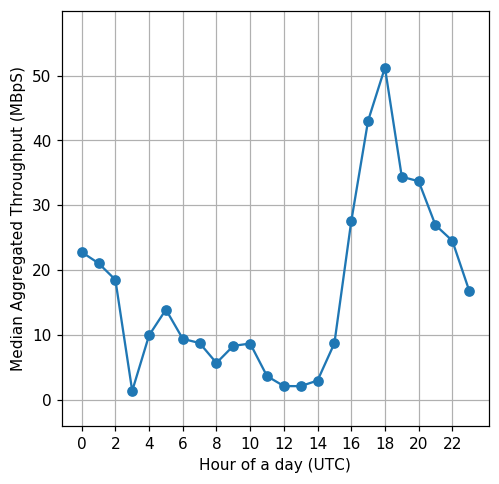

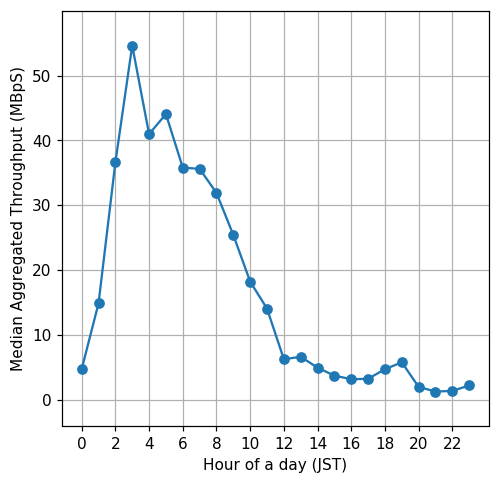

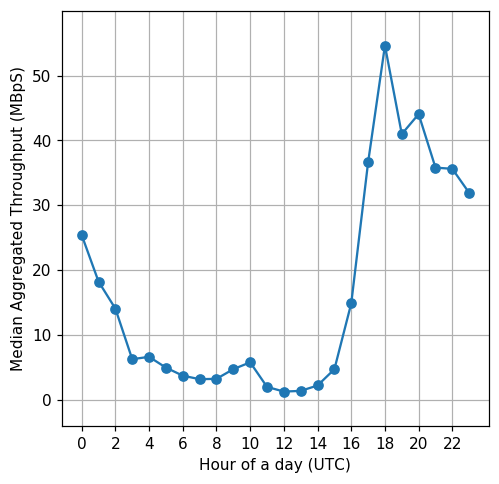

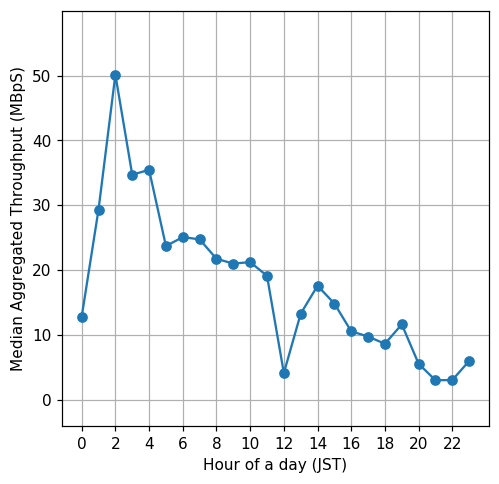

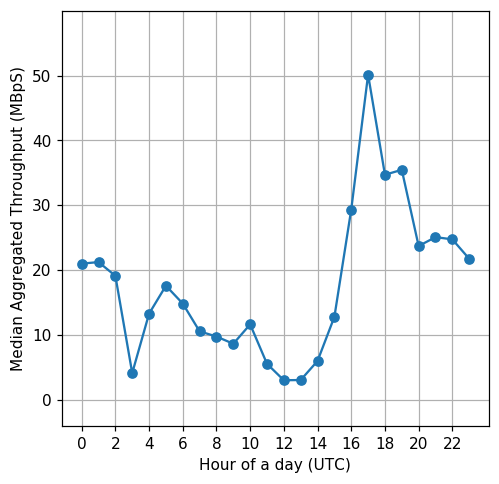

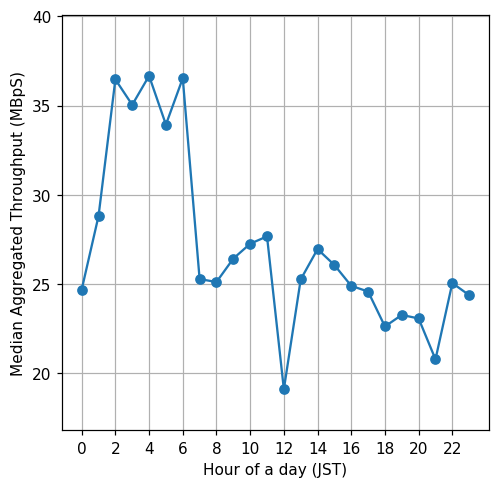

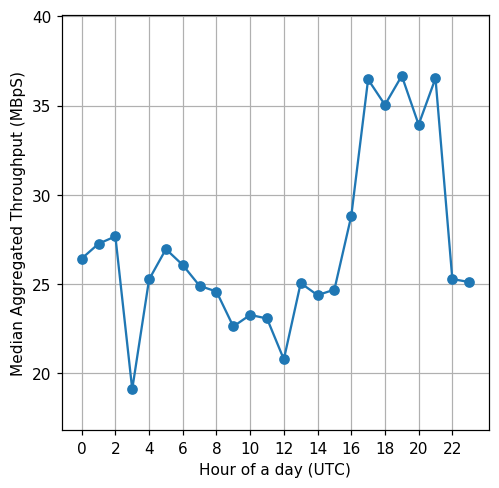

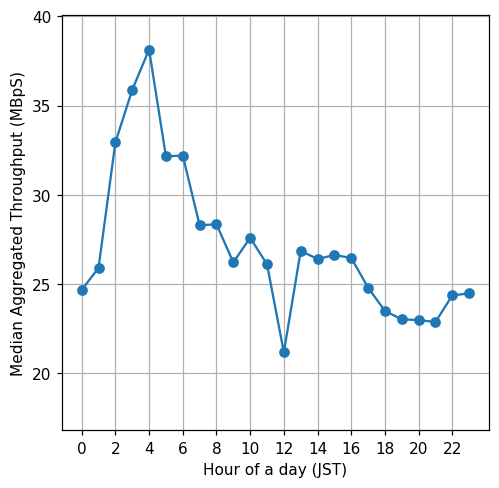

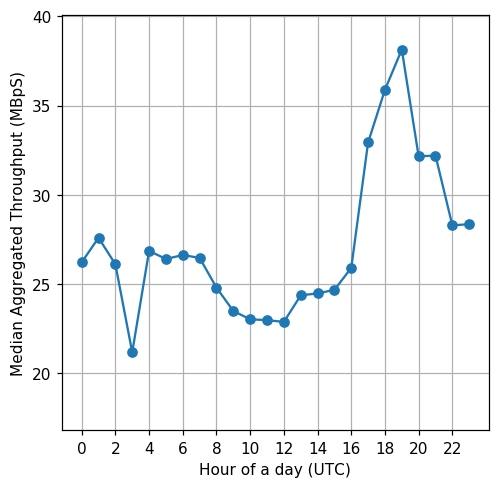

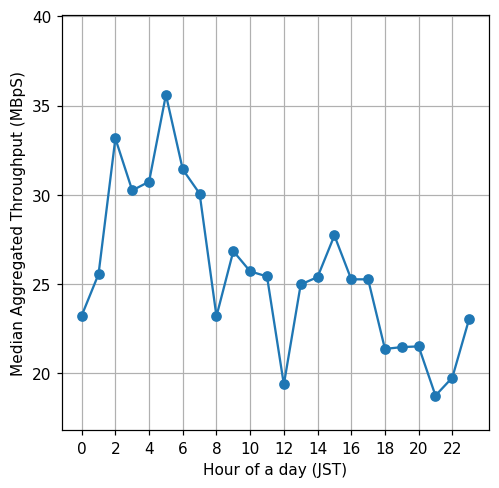

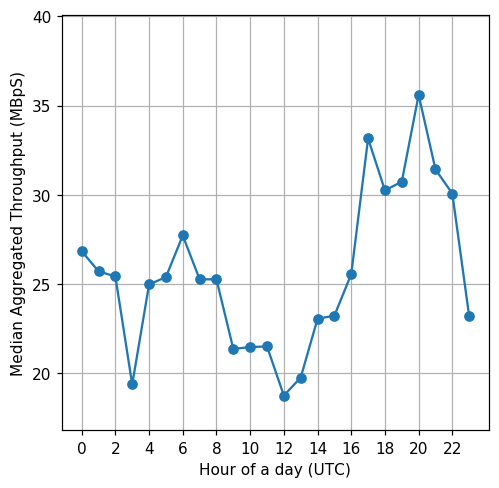

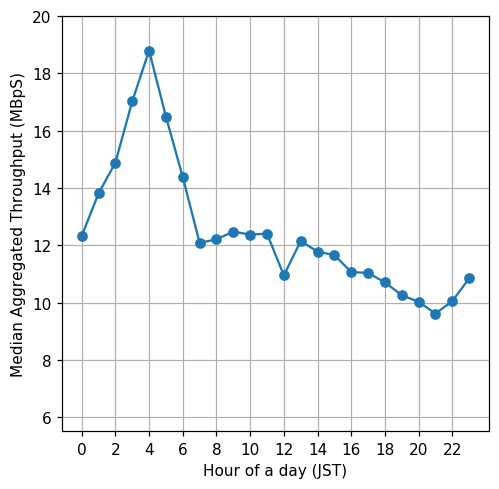

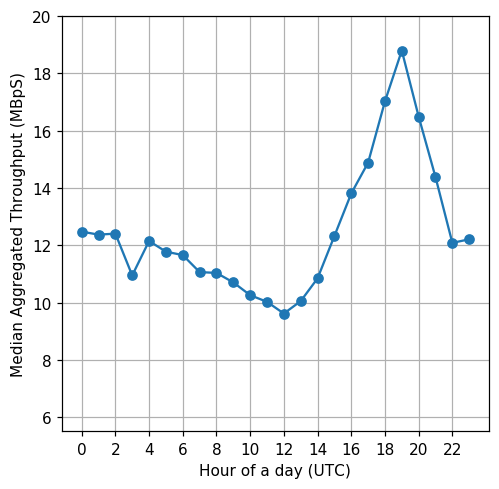

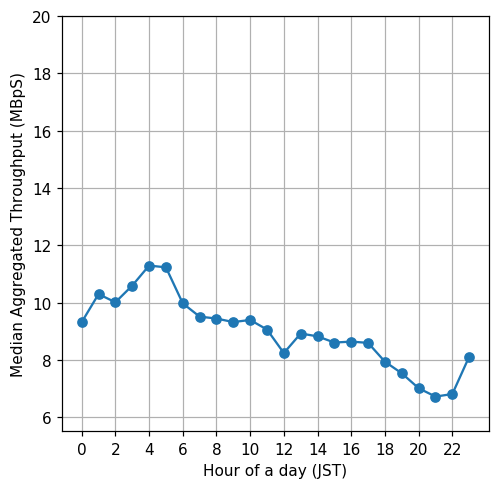

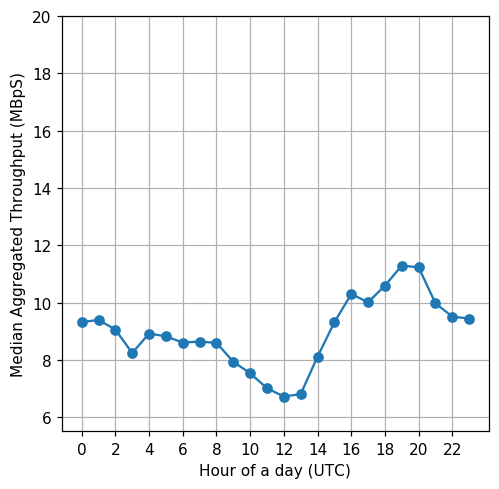

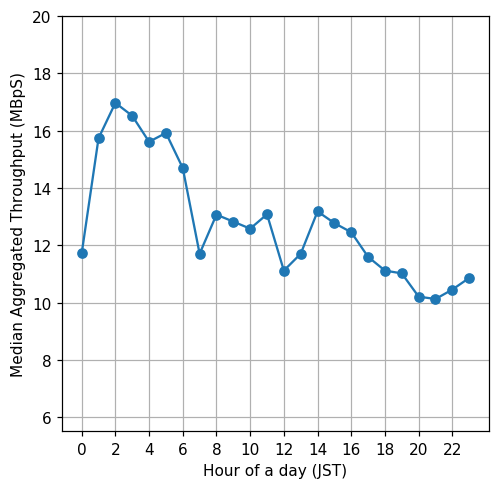

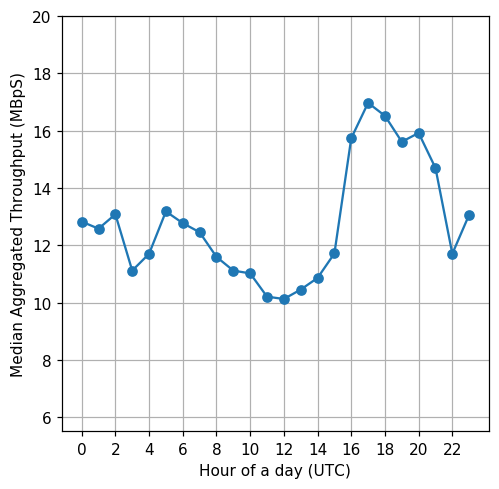

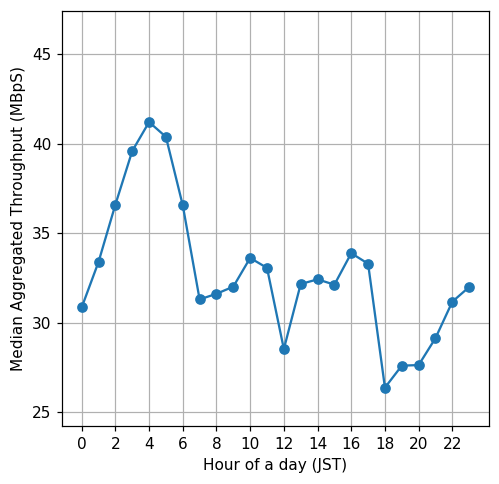

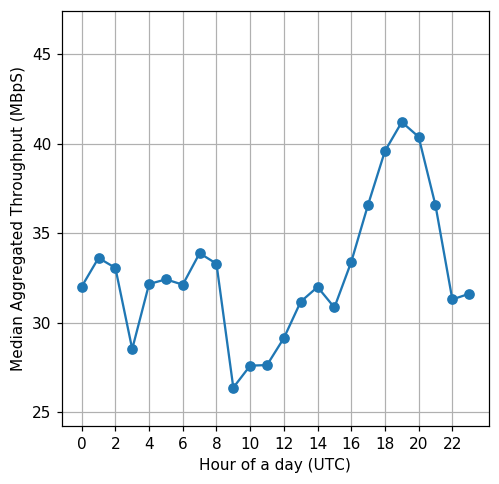

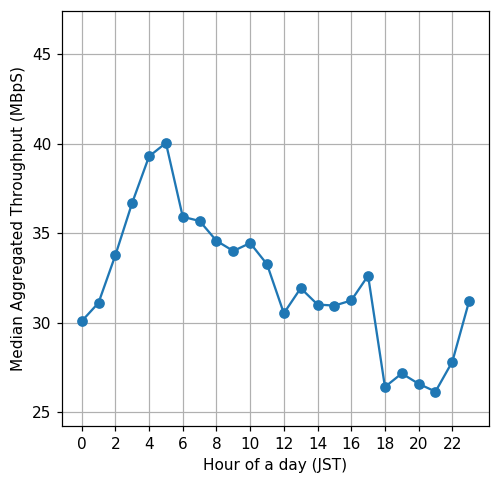

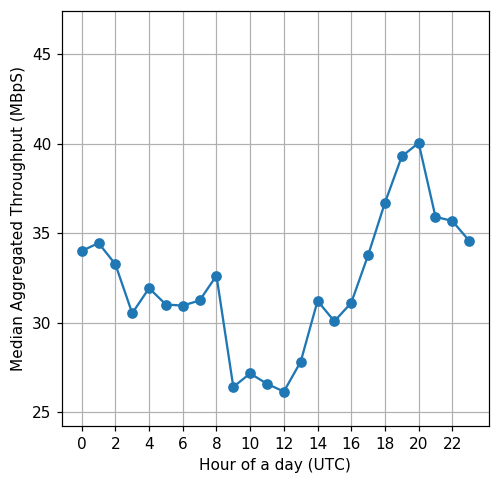

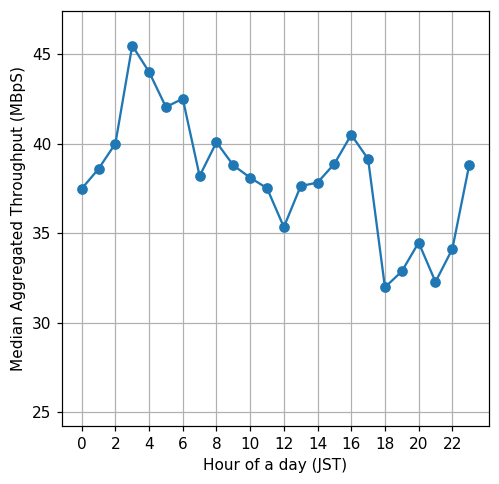

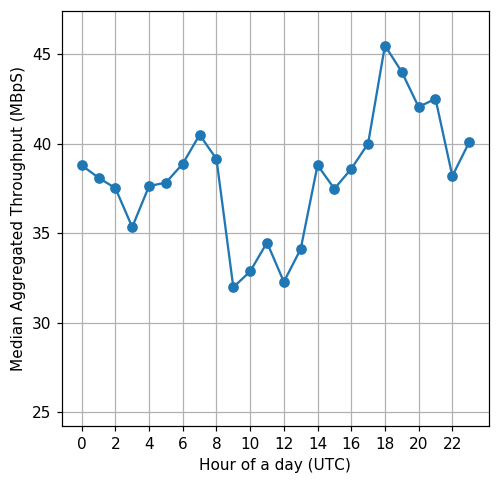

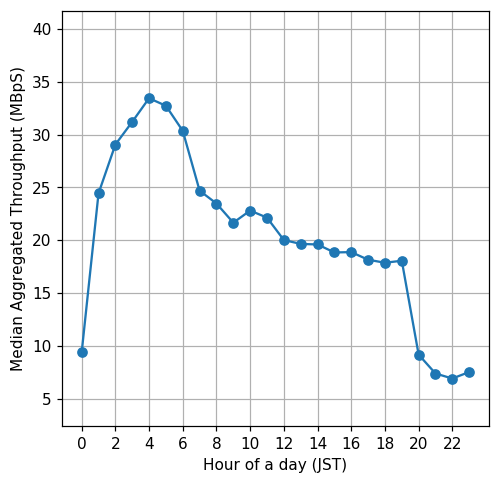

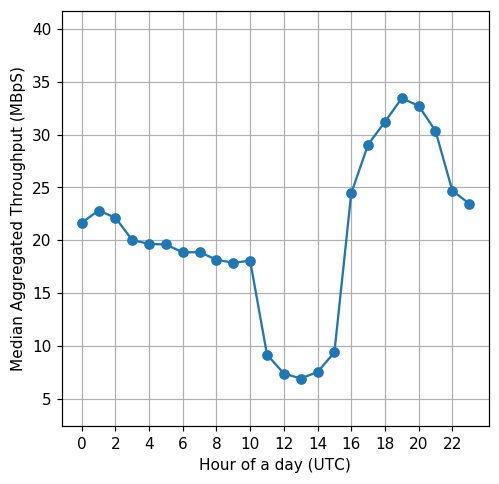

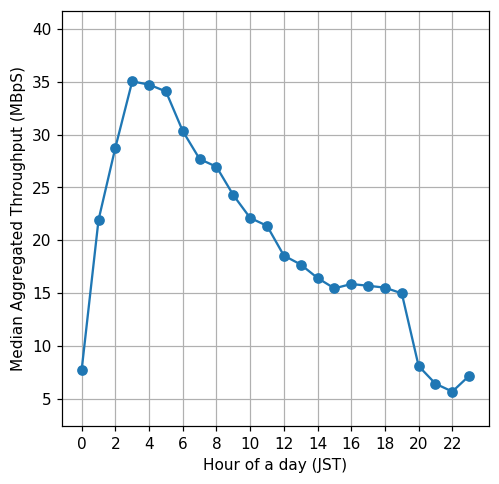

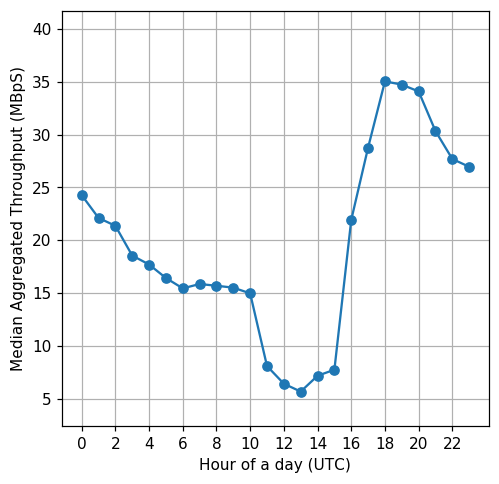

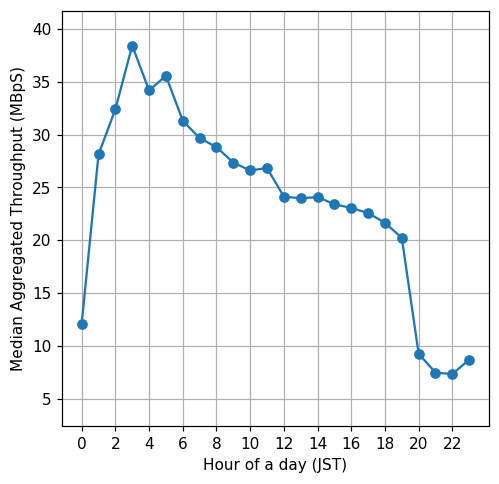

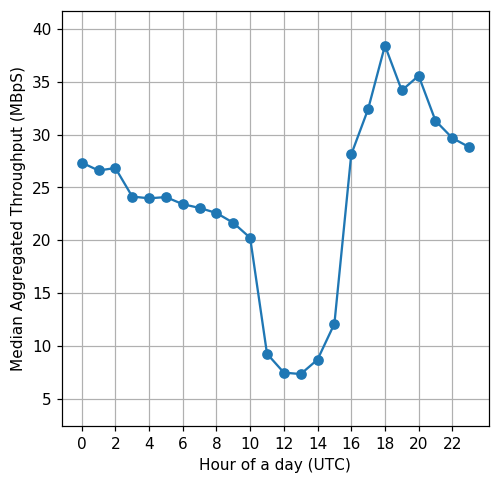

In [139]:
for asn in ASN_TO_NAME :
    area = (MAX[asn]-MIN[asn])*0.1
    data = {
        'data': bq.data[asn],
        'build': build_plot_data,
        'label': ['1 Jan - 1 Mar', '15 Mar - 15 May', '1 Jun - 1 Jul'],
        'ylim' : [MIN[asn]-area, MAX[asn]+area]
    }
    st_list  = ['01/01/2020', '03/15/2020', '06/01/2020']
    end_list = ['03/01/2020', '05/15/2020', '07/01/2020']
    
    for i in range(3):
        plot(data, [st_list[i]], [end_list[i]], f'img/jst/{path[i]}/{ASN_TO_NAME[asn]}-{asn}-median-in-one-day',True)
        plot(data, [st_list[i]], [end_list[i]], f'img/utc/{path[i]}/{ASN_TO_NAME[asn]}-{asn}-median-in-one-day')
        
#     break
#     plot(data, st_list, end_list, f'{ASN_TO_NAME[asn]}-{asn}-median-in-one-day')

In [94]:
mapper = {
    '0':'0000', '1':'0001', '2':'0010', '3': '0011', 
    '4':'0100', '5':'0101', '6':'0110', '7': '0111', 
    '8':'1000', '9':'1001', 'a':'1010', 'b': '1011', 
    'c':'1100', 'd':'1101', 'e':'1110', 'f': '1111'
}
def _convert(v):
    arr = []
    while v>0:
        arr.append(str(v%2))
        v//=2
    return "".join(arr[::-1]).rjust(8,'0')

def convert(subnet):
    ip, m = subnet.split("/")
    mask = int(m)
    if ":" in ip :
        a = "".join(list(map(lambda x: x.rjust(4,'0'), ip.split(":"))))
        i = 0
        code = ""
        while len(code) < mask :
            code = code + mapper[a[i]]
            i += 1
        return (code[:mask], mask)
    else :
        code = ""
        for slot in ip.split("."):
            code = code + _convert(int(slot))
        return (code[:mask], mask)

In [73]:
def v4_convert(ip):
    code = ""
    for slot in ip.split("."):
        code = code + _convert(int(slot))
    return code

def contain (v, subnets):
    if ":" not in v :
        ip = v4_convert(v)
    else :
        ip = ""
        a = "".join(list(map(lambda x: x.rjust(4,'0'), v.split(":"))))
        for i in range(9):
            ip = ip + mapper[a[i]]

    for binary, l in subnets:
        if ip[:l] == binary:
            return True
        
    return False